<a href="https://colab.research.google.com/github/ADebor/adebor.github.io/blob/master/notebooks/syst0002_nb1_fa23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYST0002 - Notebook 1

## Systèmes non-linéaires, plans de phase et stabilité

---

Ce premier notebook Python est destiné à approfondir et à présenter de manière plus visuelle et interactive les concepts abordés aux séances de travaux dirigés portant sur les systèmes non-linéaires. Il vise également à vous présenter l'outil notebook et à vous donner une base de code pour pouvoir expérimenter par vous-mêmes. Ce notebook est un support éducatif supplémentaires aux exercices et nous espérons qu'il vous aidera à mieux appréhender la matière et les concepts abordés. Pour plus d'information à propos des notebooks dans Google Colab, visitez [ceci](https://ledatascientist.com/google-colab-le-guide-ultime/).

---

Notebook adapté depuis [ici](https://www.normalesup.org/~doulcier/teaching/modeling/excitable_systems.html) par l'équipe de SYST0002 (ULiège, 2023).

## 0. Installation des packages Python nécessaires et importation

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install ipywidgets

In [ ]:
from functools import partial
import numpy as np
import scipy.integrate
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #used to write custom legends
%matplotlib inline

## 1. Description du système

Le système que nous allons étudier dans ce premier notebook est le modèle de Fitzhugh-Nagumo (FHN) d'un système excitable. Ce modèle est une simplification à deux dimensions du modèle de Hodgkin et Huxley qui approxime les caractéristiques électriques de cellules excitables comme les neurones par exemple.

Ce modèle FHN est un modèle simplifié permettant de générer des trains d'impulsions (potentiels d'action ou *spikes*) typiques des neurones. Les deux variables du modèle sont le potentiel de membrane $v$ et une variable de récupération $w$. La dynamique du système est décrite par les équations

$$
\begin{align*}
&\dot{v} = F_1(v, w) = v - v^3 - w + I_{ext}\\
&\tau \dot{w} = \tau F_2(v, w) = v + a - bw,
\end{align*}
$$

où $I_{ext}$ représente le stimulus externe (*i.e.* un courant appliqué, externe à la cellule), autrement dit l'*entrée* de votre système. Nous considérerons cependant l'entrée comme fixe dans ce notebook.

Nous allons étudier la dynamique de ce système, et comment celui-ci peut modéliser un potentiel d'action.
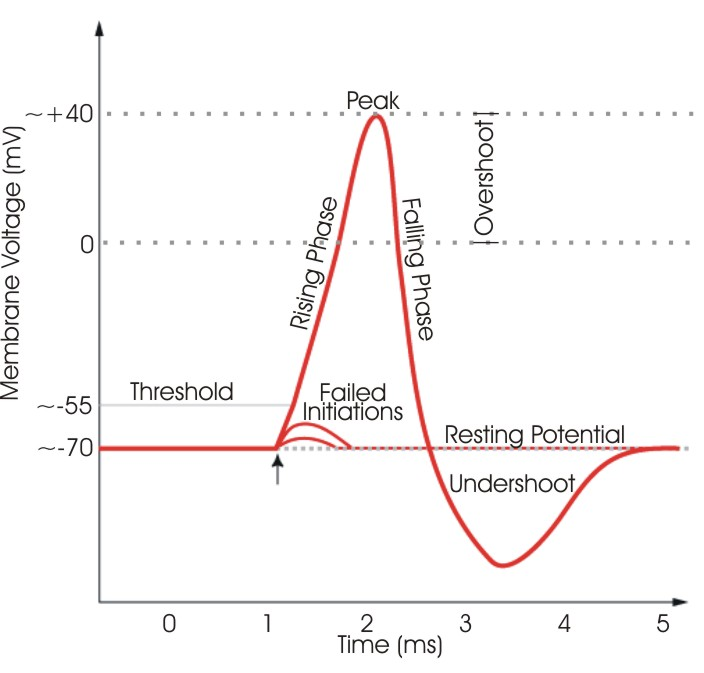

(image de animalresearch.info)

## 2. Évolution temporelle

Dans cette section, nous allons implémenter le modèle FHN et simuler l'évolution *temporelle* des variables $v$ et $w$ pour plusieurs valeurs de $I_{ext}$. En effet, la valeur du courant appliqué influence le comportement du modèle étudié. Nous allons considérer 3 scénarios, pour lesquels les paramètres $a, b$ et $\tau$ prennent des valeurs typiques et seul le paramètre (ou entrée fixe) $I_{ext}$ est modifié.

In [ ]:
scenarios = [
     {"a":.3, "b":1.4, "tau":20, "I":0},
     {"a":.3, "b":1.4, "tau":20, "I":0.23},
     {"a":.3, "b":1.4, "tau":20, "I":0.5}
]
time_span = np.linspace(0, 200, num=1500) # durée et nombre d'instants de nos simulations

Implémentons les ODEs du modèle :

In [ ]:
def fitzhugh_nagumo(x, t, a, b, tau, I):
    """Dérivée temporelle du modèle FHN.
    Args:
       x (array size 2): [Potentiel membranaire v, Variable de récupération w]
       a, b (float): Paramètres.
       tau (float): Échelle temporelle.
       t (float): Temps (non utilisé)
       I (float): Courant de stimulus constant.
    Return: dx/dt (array size 2)
    """
    return np.array([x[0] - x[0]**3 - x[1] + I,
                     (x[0] + a - b * x[1])/tau])

Traçons maintenant l'évolution temporelle des variables du modèle. N'hésitez pas à jeter un oeil à la documentation des différentes fonctions utilisées comme [partial](https://docs.python.org/3/library/functools.html#functools.partial) ou encore [odeint](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html). Nous allons dans un premier temps générer des conditions initiales ; ici, nous allons utiliser des petites perturbations autour du potentiel de repos (*i.e.* nous faisons varier $v(t=0)$ autour de sa valeur de repos). Ensuite, on peut résoudre le système d'équations pour $v$ et $w$ pour différents instants $t$ à partir de ces conditions initiales. N'hésitez pas à faire varier les paramètres de la fonction pour en comprendre l'utilité.

In [ ]:
def generate_displaced_traj(param, dmin=-0.5, dmax=0.5,time_span=np.linspace(0,200, 1000), number=20):
    """Génération de trajectoires pour v, w, pour différentes CI autour de la valeur de repos.
    Args:
      param (dict): Paramètres du modèle à utiliser.
      dmax (float): Déplacement maximum de la CI sur v autour de la valeur au repos.
      time_span (array): Intervalle de temps considéré pour la simulation.
      number (int): Nombre de déplacements sur la CI de v à générer.
    """
    # Partons du point de repos
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=[0,0],
                                                      t= np.linspace(0,999, 1000))[-1]

    # et déplaçons le potentiel.
    traj = []
    for displacement in np.linspace(dmin, dmax, number):
        traj.append(scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                          y0=ic+np.array([displacement,0]),
                                          t=time_span
                                           ))
    return traj

In [ ]:
# Générons les trajectoires et stockons les dans un dictionnaire
trajectories = {}
for i,param in enumerate(scenarios):  # pour les différents scénarios définis au début
    trajectories[i] = generate_displaced_traj(param,
                                       number=2,            # nombre de déplacements des CIs
                                       time_span=time_span, # durée de simulation de la trajectoire
                                       dmin=-.5, dmax=.5)   # valeurs min et max de déplacement

In [ ]:
# Dessinons les trajectoires
fig, ax = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios),5))
for i,param in enumerate(scenarios):
        ax[i].set(xlabel='Time', ylabel='v, w',
                     title='{}'.format(param))
        for j in range(len(trajectories[i])):
            v = ax[i].plot(time_span,trajectories[i][j][:,0], color='C0')
            w = ax[i].plot(time_span,trajectories[i][j][:,1], color='C1', alpha=.5)
        ax[i].legend([v[0],w[0]],['v','w'])
plt.tight_layout()

On voit bien que, comme nous l'avons imposé, les conditions initiales sur $v$ varient autour d'une certaine valeur (le potentiel de repos) (ce qui n'est pas le cas de la variable $w$). Comme annoncé, on remarque également différents comportements en fonction du paramètre $I_{ext}$ du modèle. Nous allons investiguer cela dans la suite de ce notebook.

## 3. Nullclines et plan de phase

Dans cette section, nous allons dériver l'expression des nullclines du système et les dessiner dans le plan de phase. Nous dessinerons ensuite le champ de vecteurs dans ce plan.

---

Pour rappel, les nullclines sont les courbes dans le plan 2D (on parlera plus généralement de variété ou *manifold* lorsque l'on travaille dans un espace à plusieurs dimensions) pour lesquelles la variation temporelle d'une des deux variables est nulle. Ici, ces deux courbes sont donc données par
$$
\dot{v} = 0 \Leftrightarrow w = v - v^3 + I_{ext}
$$
pour la $v$-nullcline, et
$$
\dot{w} = 0 \Leftrightarrow w = \frac{1}{b}(v+a).
$$
pour la $w$-nullcline.


Dessinons-les dans le plan de phase :

In [ ]:
def plot_isocline(ax, a, b, tau, I, color='k', style='--', opacity=.5, vmin=-1,vmax=1):
    """Trace les nullclines du modèle FHN."""
    v = np.linspace(vmin,vmax,100)
    ax.plot(v, v - v**3 + I, style, color=color, alpha=opacity)
    ax.plot(v, (v + a)/b, style, color=color, alpha=opacity)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, sc in enumerate(scenarios):
    plot_isocline(ax[i], **sc)
    ax[i].set(xlabel='v', ylabel='w',
              title='{}'.format(sc))

Nous pouvons à nouveau remarquer que différentes configurations des nullclines se dessinent en fonction de la valeur de $I_{ext}$. En particulier, le nombre ainsi que la position des intersections entre ces courbes varient. Nous verrons par la suite que la *nature* de ces intersections varie également.

---

Dessinons à présent le champ de vecteurs du système. Pour rappel, à chaque point du plant de phase, donc à chaque couple $(v, w)$, est associé un vecteur $(\dot{v}, \dot{w})$. Pour un couple $(v, w)$ donné, le vecteur associé représente la direction (et l'intensité) du flux à cet endroit du plan de phase. À nouveau, n'hésitez pas à vous renseigner sur les fonctions utilisées comme [streamplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.streamplot.html).

In [ ]:
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    # Calculons le champ de vecteurs pour une grille de valeurs de v et w
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)

    dx,dy = fitzhugh_nagumo([X,Y],0,**param)

    # Tracons le champ de vecteurs
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.1))

    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, sc in enumerate(scenarios):
    xrange = (-1, 1)
    yrange = [(1/sc['b'])*(x-sc['a']) for x in xrange]
    plot_vector_field(ax[i], sc, xrange, yrange)
    ax[i].set(xlabel='v', ylabel='w',
          title='{}'.format(sc))

Ces champs de vecteurs nous renseignent sur le comportement du système en fonction des conditions initiales pour $v$ et $w$, et ce en fonction du paramètre $I_{ext}$.

## 4. Points fixes et stabilité

Dans cette section, nous allons identifier les différents points d'équilibre du système en fonction de la valeur du stimulus $I_{ext}$. Nous allons ensuite étudier la stabilité de ces points d'équilibre.

---

Pour rappel, les points d'équilibre sont tels que la variation temporelle des variables en ces points est nulle. Autrement dit, pour un point fixe donné par $(v^*, w^*)$, on a $(\dot{v}(v^*, w^*), \dot{w}(v^*, w^*)) = (0, 0)$. Graphiquement, dans le plan de phase, cela correspond donc aux points d'intersection entre les nullclines.

Ici, les points d'équilibre du système sont donc les couples $(v^*, w^*)$ qui vérifient

$$
\begin{align}
&\dot{v}(v^*, w^*) = 0 \Leftrightarrow w^* = v^* - v^{*3} + I_{ext}, \\
\text{et } \; & \dot{w}(v^*, w^*) = 0 \Leftrightarrow w^* = \frac{1}{b}(v^*+a).
\end{align}
$$
En tenant compte de la seconde équation, nous pouvons supprimer la dépendance de la première équation en $w^*$. La première équation devient donc    
$$
v^{*3} + \left(\frac{1}{b} - 1\right)v^* - I_{ext} + \frac{a}{b} = 0
$$
que nous pouvons résoudre pour $v^*$.


Résolvons ce système numériquement à l'aide de [numpy.roots](https://numpy.org/doc/stable/reference/generated/numpy.roots.html) (et ne gardons que les solutions réelles) :

In [ ]:
def find_roots(a,b,I, tau):
    """Calcule les points d'équilibre..
    """
    # Les coefficients de l'équation polynomiale en v* sont :
    # 1           * v**3
    # 0           * v**2
    # (1/b - 1)   * v**1
    # (a/b - I) * v**0
    coef = [1, 0, 1/b - 1, a/b - I]

    # Seules les racines réelles nous intéressent.
    # np.isreal(x) retourne True seulement si x est réel.
    # La ligne suivante filtre ainsi les racines déterminées
    # par np.roots et ne gardent que les racines réelles.
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]

    # Nous pouvons donc déterminer les couples (v*, w*)
    # d'équilibre à partir des racines en v* en utilisant
    # la seconde équation.
    return [[r, r - r**3 + I] for r in roots]

eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

# Affichons les points d'équilibre :
eqnproot

À nouveau, et comme attendu, on observe des résultats différents en fonction de la valeur de $I_{ext}$. Vous pouvez ainsi mettre en relation le nombre de points d'équilibre déterminés ici et le nombre de points d'intersection entre les nullclines observés précédemment.

---

Nous avons désormais les points d'équilibre du système. Déterminons maintenant la nature de ces points d'équilibre : stable, instable, point de selle, ... ?

Pour rappel, il faut pour se faire étudier le signe des valeurs propres de la matrice jacobienne du flux évaluée aux points d'équilibre. Cette matrice apparaît en effet lors de la linéarisation du système autour de ses points d'équilibre, et ses valeurs propres influent sur le caractère convergent ou divergent de l'évolution temporelle d'une perturbation exercée sur le système en un point d'équilibre.

Voici un tableau récapitulatif des principaux types de point d'équilibre pour un système 2D ainsi que des critères de stabilité sur les parties réelles des valeurs propres $\lambda_i$ :

| Type | Valeurs propres $\lambda_1, \lambda_2$| Stable | Instable |
|---   | ---                                   | ---     |---       |
| Noeud (*Node*) | Réelles et de même signe | $<0$ | $>0$ |
| Selle (*Saddle*) | Réelles et de signes contraires | / | / |
| Spirale (*Focus*) | Complexes (conjuguées) | $<0$ | $>0$ |
| Centre (*center*) | Imaginaires | / | / |


La matrice jacobienne est ici donnée par
$$
J =
\begin{pmatrix}
\frac{∂F_1(v, w)}{∂v} & \frac{∂F_1(v, w)}{∂w} \\
\frac{∂F_2(v, w)}{∂v} & \frac{∂F_2(v, w)}{∂w}
\end{pmatrix}
 =
\begin{pmatrix}
1-3v^2 & -1 \\
\frac{1}{\tau} & -\frac{b}{\tau}
\end{pmatrix}.
$$

Évaluons maintenant cette matrice aux différents points d'équilibre du système et calculons les valeurs propres afin de caractériser la stabilité de ces points.  

In [ ]:
# Définissons un code couleur pour représenter les types de point d'équilibre :
EQUILIBRIUM_COLOR = {'Noeud stable':'C0',
                    'Noeud instable':'C1',
                    'Point de selle':'C4',
                    'Spirale stable':'C3',
                    'Spirale instable':'C2',
                    'Centre':'C5'}

In [ ]:
def jacobian_fitznagumo(v, w, a, b, tau, I):
    """ Matrice jacobienne du système FHN linéarisé.
    Args
    ====
        v (float): Potentiel membranaire
        w (float): Variable de récupération
        a,b (float): Paramètres
        tau (float): Constante de temps.
    Return: np.array 2x2"""
    return np.array([[1 - 3 * v**2, -1],
                       [1/tau, -b/tau]])

In [ ]:
def stability(jacobian):
    """ Détermine la stabilité d'un point d'équilibre étant donné la matrice jacobienne associée.
    Args:
        jacobian (np.array 2x2): La matrice jacobienne au point d'équilibre.
    Return:
        (string) Nature du point d'équilibre.
    """

    eigv = np.linalg.eigvals(jacobian)

    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Centre"
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Point de selle"
    else:
        stability = ' instable' if all(np.real(eigv)>0) else ' stable'
        nature = ('Spirale' if all(np.imag(eigv)!=0) else 'Noeud') + stability
    return nature

In [ ]:
eqstability = {}
for i, param in enumerate(scenarios):
    eqstability[i] = []
    for e in eqnproot[i]:
        J = jacobian_fitznagumo(e[0],e[1], **param)
        eqstability[i].append(stability(J))
eqstability

Nous observons à présent que, en plus d'obtenir un nombre de points d'équilibre différent pour différentes valeurs de $I_{ext}$, la nature de ceux-ci diffère également en fonction de la valeur de $I_{ext}$.

## 5. Plan de phase complet

Dans cette dernière section, nous allons générer le plan de phase complet, reprenant nullclines, champ de vecteurs, points d'équilibre et stabilité. Nous mettrons enfin en relation ce plan de phase pour différentes valeurs de $I_{ext}$ avec les traces temporelles des variables $v$ et $w$ générées au début du notebook. Pour ce faire, nous tracerons des trajectoires de couples $(v, w)$ au cours du temps dans le plan de phase, et ce pour des conditions initiales légèrement différentes .

In [ ]:
# Définissons les couleurs de nos trajectoires
traj_colors = ['olive', 'cyan', 'orange']

def plot_phase_diagram(param, ax=None, title=None):
    """Trace un plan de phase complet, incluant nullclines, champ de vecteurs, points d'équilibre et nature, et quelques trajectoires.
    """
    if ax is None:
        ax = plt.gca()
    if title is None:
        title = "Espace de phase, {}".format(param)

    ax.set(xlabel='v', ylabel='w', title=title)

    # Nullclines et champ de vecteurs
    xlimit = (-1.5, 1.5)
    ylimit = (-.6, .9)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_isocline(ax, **param, vmin=xlimit[0],vmax=xlimit[1])

    # Points d'équilibre
    eqnproot = find_roots(**param)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **param)) for e in eqnproot]
    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n])

        # Traçons la trajectoire pour des CI (v(t=0), w(t=0)) légèrement différentes des points d'équilibre stables
        # (comme lorsque nous avons généré la trace temporelle au début du notebook)
        dmax=1.
        number=3
        time_span = np.linspace(0, 200, num=1500)
        if n[-7:] == ' stable':
            for i, perturb in enumerate(np.linspace(0, dmax, number)):  # ce paramètre contrôle la perturbation initiale sur v
                ic = [e[0]+abs(perturb*e[0]),e[1]]
                traj = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                  y0=ic,
                                                  t=time_span)
                ax.plot(traj[:,0], traj[:,1], '--', color=traj_colors[i], linewidth=1.25)

    # Legend
    labels = frozenset(eqstability)
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels,
           loc='lower right')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
for i, param in enumerate(scenarios):
    plot_phase_diagram(param, ax[i])

Nous pouvons donc enfin mettre en relation les comportements temporels du système observés en début de notebook avec le plan de phase généré et les trajectoires tracées dessus. En effet, nous observons que, en fonction de la valeur de $I_{ext}$, les points vont décrire des trajectoires différentes dans le plan de phase, et les variations des variables $v$ et $w$ au cours du temps sont bien un miroir de celles observées pour la trace temporelle. Par exemple, le train d'impulsions observé pour une valeur intermédiaire de $I_{ext}$ est bien une représentation temporelle de la trajectoire en cycles observée dans le plan de phase.

---
Pour terminer, intéressons-nous de plus près au système linéarisé. Ce système linéaire décrit la dynamique d'une petite perturbation sur les positions d'équilibre des variables $v$ et $w$. Si nous notons cette perturbation $\eta = \left(\eta_v, \eta_w\right)$ définie avec $\eta_v = v-v^*$ et $\eta_w = w-w^*$ localement autour d'un point d'équilibre $(v^*, w^*)$, la dynamique de $\eta$ est décrite par
$$
\begin{pmatrix}
\dot{\eta}_v \\ \dot{\eta}_w
\end{pmatrix}
=
J |_{(v^*, w^*)}
\begin{pmatrix}
\eta_v \\ \eta_w
\end{pmatrix}.
$$

En reprenant la même marche à suivre que ci-avant, regardons maintenant (pour le premier scénario uniquement, mais vous pouvez faire de même pour les autres) comment ce modèle linéarisé se comporte comparativement au modèle non-linéaire, en fonction de la position initiale :

In [ ]:
def fitzhugh_nagumo_linearized(x, t, eq_x, a, b, tau, I):
    """Modèle linéarisé du système FHN.
    """
    eta = x - eq_x
    eq_v = eq_x[0]
    eq_w = eq_x[1]
    return np.matmul(jacobian_fitznagumo(eq_v, eq_w, a, b, tau, I), eta)

In [ ]:
# Définissons les couleurs de nos trajectoires (les couleurs foncées ('dark') seront associées aux trajectoires du modèle linéarisé)
traj_colors = ['lightcoral', 'darkred', 'lightblue', 'darkblue', 'lightgreen', 'darkgreen']

def plot_phase_diagram(param, ax=None, title=None):
    """Trace un plan de phase complet, incluant nullclines, champ de vecteurs, points d'équilibre et nature, et quelques trajectoires.
    """
    if ax is None:
        ax = plt.gca()
    if title is None:
        title = "Espace de phase, {}".format(param)

    ax.set(xlabel='v', ylabel='w', title=title)

    # Nullclines et champ de vecteurs
    xlimit = (-.8, -.2)
    ylimit = (-.35, -.25)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_isocline(ax, **param, vmin=xlimit[0],vmax=xlimit[1])

    # Points d'équilibre
    eqnproot = find_roots(**param)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **param)) for e in eqnproot]

    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n])

        # Traçons la trajectoire pour des CI (v(t=0), w(t=0)) différentes des points d'équilibre, proches et plus lointaines.
        time_span = np.linspace(0, 200, num=1500)
        if n[-7:] == ' stable':
          for i, perturb in enumerate([0.05, 0.4, 0.6]):  # les perturbations sont "hardcodées" pour observer différents comportements, n'hésitez-pas à modifier ces valeurs.

            ic = [e[0]+abs(perturb*e[0]),e[1]]
            traj = scipy.integrate.odeint(
                                      partial(fitzhugh_nagumo, **param),
                                      y0=ic,
                                      t=time_span
                                      )
            ax.plot(traj[:,0], traj[:,1], '--', color=traj_colors[0+2*i], linewidth=1.25)

            param_lin = param.copy()
            param_lin['eq_x'] = e
            traj_lin = scipy.integrate.odeint(
                                      partial(fitzhugh_nagumo_linearized, **param_lin),
                                      y0=ic,
                                      t=time_span
                                      )
            ax.plot(traj_lin[:,0], traj_lin[:,1], '--', color=traj_colors[1+2*i], linewidth=1.25)


    # Legend
    labels = frozenset(eqstability)
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels,
           loc='lower right')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 6))
plot_phase_diagram(scenarios[0], ax)

On voit donc sur le graphe généré ci-dessus que le modèle linéarisé n'a de sens que localement, au voisinage du point d'équilibre autour duquel le système de départ est linéarisé. En effet, les courbes rouge clair et rouge foncé se confondent pratiquement, et l'étude de l'évolution temporelle de la perturbation a du sens pour étudier la stabilité du point d'équilibre. Cependant, on voit que, plus l'on s'éloigne de ce point d'équilibre, plus l'approximation linéaire perd de son sens. La courbe bleu foncé, bien que décrivant une trajectoire similaire à la courbe bleu clair, n'est clairement pas superposée à celle-ci, tandis que les courbes vertes ne décrivent absolument pas la même trajectoire. Le système linéaire ne tient ici pas compte du profil complet (global) du champ de vecteur.

## 6. Pour aller plus loin

Il peut également être intéressant de représenter le diagramme de bifurcation d'une variable à l'équilibre en fonction du stimulus externe $I_{ext}$. Autrement dit, un tel diagramme représente l'évolution d'un point d'équilibre en fonction d'un paramètre du système (ici $I_{ext}$). Il faut donc, pour différentes valeurs de ce paramètre, résoudre le système à l'équilibre pour trouver la valeur de la variable correspondante. Ainsi, on obtient, par exemple, la courbe $v^*(I_{ext})$. N'hésitez pas à essayer de tracer une telle courbe pour vous exercer.

Un autre bon exercice consiste à reproduire l'analyse que nous avons réalisée ci-dessus pour un autre système (vu au TP par exemple).